In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../.'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from core.utils import process_sample
from core.models.base_transformer_model import SimpleTransformerEncoder as BaseTransformerModel
from core.models.hierarchical_transformer import HierarchicalTransformer
import torch
import numpy as np
import os

In [3]:
# Initialize the models
htformer_weights = ".././models/final/hierarchical_transformer_f201_d64_h2_s1_t1_do0.1_20250701_1555.pth"
stformer_weights = ".././models/final/base_hierarchical_transformer_f201_d64_h2_do0.1_20250701_1352.pth"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
htformer = HierarchicalTransformer(
    d_model=64,
    nhead=2,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    num_joints=33,
    num_frames=201,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

htformer.load_state_dict(torch.load(htformer_weights))

# Base
stformer = BaseTransformerModel(
    d_model=64,
    nhead=2,
    num_layers=2,
    num_classes=3,
    num_joints=33,
    num_frames=201,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

stformer.load_state_dict(torch.load(stformer_weights))


<All keys matched successfully>

In [6]:
# Prepare the dataset
labels = {"squats": 0, "deadlifts": 1, "shoulder_press": 2}
temp_samples = []
sequence_lengths = []

# Load all samples
for exercise, label in labels.items():
    folder_path = os.path.join(".././data/keypoints/testing", exercise)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist")
        continue
        
    for file in os.listdir(folder_path):
        if file.endswith(".npy"):
            path = os.path.join(folder_path, file)
            try:
                sample = np.load(path)
                print(sample.shape)
                temp_samples.append((sample, label))
                sequence_lengths.append(sample.shape[0])
            except Exception as e:
                print(f"Error loading {path}: {e}")

if not temp_samples:
    raise ValueError("No samples loaded!")

# Determine max_frames using percentile to avoid extreme outliers
max_frames = 201

# Filter out sequences that are too long
filtered_samples = []
filtered_lengths = []
for i, (sample, label) in enumerate(temp_samples):
    if sequence_lengths[i] <= max_frames:
        filtered_samples.append((sample, label))
        filtered_lengths.append(sequence_lengths[i])
    else:
        print(f"Filtering out sample with length {sequence_lengths[i]}")

print(f"Kept {len(filtered_samples)} out of {len(temp_samples)} samples")

# Create padded arrays with attention masks
X = []
y = []
attention_masks = []
final_sequence_lengths = []

for sample, label in filtered_samples:
    padded_sample, attention_mask, seq_len = process_sample(sample, max_frames)
    X.append(padded_sample)
    y.append(label)
    attention_masks.append(attention_mask)
    final_sequence_lengths.append(seq_len)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
attention_masks = np.array(attention_masks)
final_sequence_lengths = np.array(final_sequence_lengths)

(98, 33, 4)
(208, 33, 4)
(86, 33, 4)
(73, 33, 4)
(110, 33, 4)
(89, 33, 4)
(86, 33, 4)
(109, 33, 4)
(95, 33, 4)
(154, 33, 4)
(158, 33, 4)
(78, 33, 4)
(87, 33, 4)
(75, 33, 4)
(97, 33, 4)
Filtering out sample with length 208
Kept 14 out of 15 samples


In [11]:
# Loaders
X = X[:, :, :, :3]# get x y z only

# Convert to PyTorch tensors
X_tensors = torch.tensor(X, dtype=torch.float32).to(device)
mask_tensor = torch.tensor(attention_masks, dtype=torch.float32).to(device)

In [12]:
X_tensors.shape, mask_tensor.shape

(torch.Size([14, 201, 33, 3]), torch.Size([14, 201]))

In [13]:
def infer(model, X: torch.tensor, mask: torch.tensor = None):
    model.eval()
    outputs = []

    with torch.no_grad():
        if mask is None:
            for x in X:
                x = x.unsqueeze(0)
                output = model(x)
                preds = output.argmax(1)
                outputs.extend(preds.cpu().numpy())
        else:
            for x, m in zip(X, mask):
                x = x.unsqueeze(0)
                m = m.unsqueeze(0)  # make sure mask is batched too
                output = model(x, m)
                preds = output.argmax(1)
                outputs.extend(preds.cpu().numpy())
    
    return outputs


In [14]:
# Perform inference for both models
htformer_outputs = infer(htformer, X_tensors, mask=mask_tensor)
stformer_outputs = infer(stformer, X_tensors, mask=None)

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

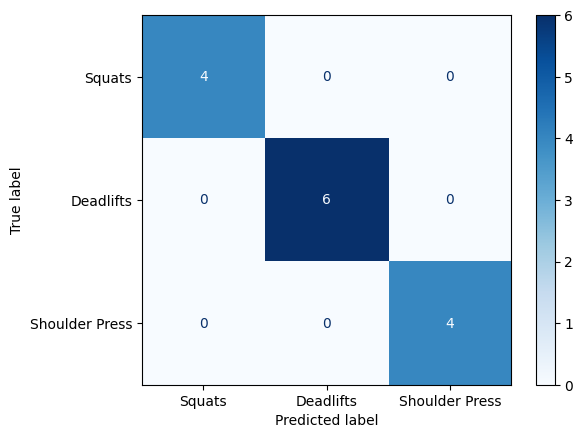

In [20]:
ConfusionMatrixDisplay.from_predictions(y, htformer_outputs,
                                        display_labels=class_names,
                                        cmap='Blues')

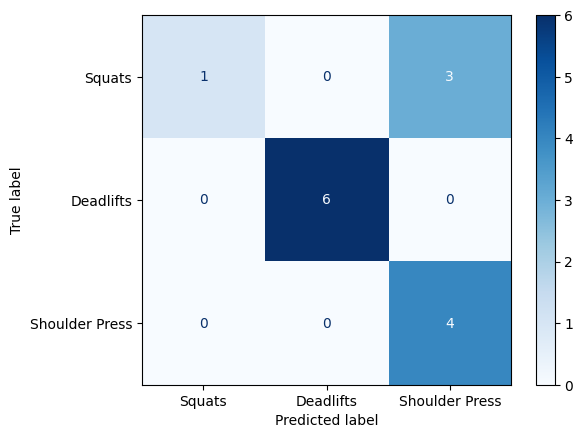

In [21]:
ConfusionMatrixDisplay.from_predictions(y, stformer_outputs,
                                        display_labels=class_names,
                                        cmap='Blues')

In [22]:
# reports
print("HTFormer Real World Data Inference")
print(classification_report(y, htformer_outputs))
print("-----------------------------------------------------")
print("STFormer Real World Data Inference")
print(classification_report(y, stformer_outputs))

HTFormer Real World Data Inference
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

-----------------------------------------------------
STFormer Real World Data Inference
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      1.00      1.00         6
           2       0.57      1.00      0.73         4

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.71        14
weighted avg       0.88      0.79      0.75        14

